In [2]:
from glob import glob; from os import path
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, matplotlib as mpl, seaborn as sns


import scienceplots
mpl.rcdefaults()
plt.style.use(['science','no-latex', 'nature'])
mpl.rcParams['figure.dpi'] = 72*2
mpl.rcParams['lines.linewidth'] = .5
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['font.size'] = 10
# change title font 
mpl.rcParams['figure.figsize'] = (7, 2.5)

%matplotlib widget

def nm_to_ev(nm):
    return 1239.84187/nm
def ev_to_nm(ev):
    return 1239.84187/ev

import warnings
warnings.filterwarnings('ignore')

def energy_ticks(ax = None):
    """
    Add energy axis ticks to the top of the plot.   
    Assumes that the x-axis is wavelength in nm.   
    To add a label use `energy_ticks(ax).set_xlabel('Energy (eV)')`
    """
    if ax is None:  ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    return ax.secondary_xaxis('top', functions=(nm_to_ev, ev_to_nm))

# look at all reflection spectra


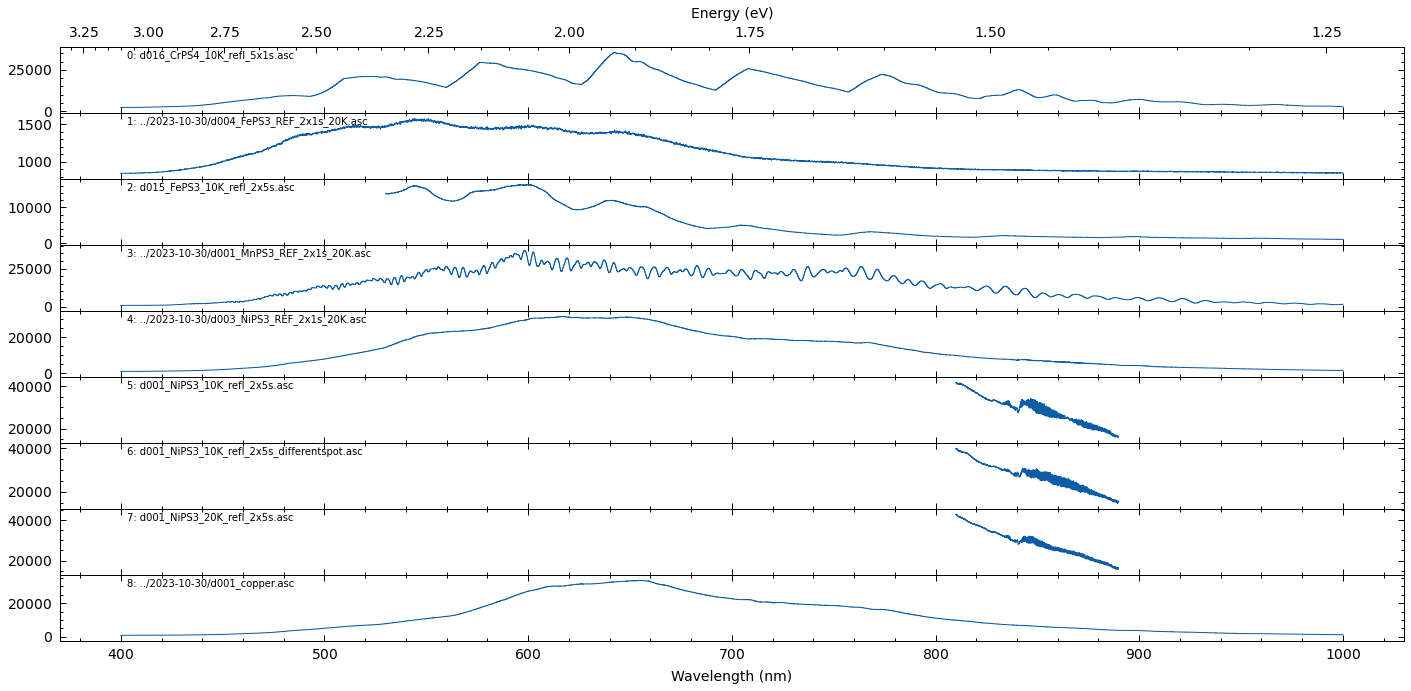

In [2]:
paths = glob("d*refl*.asc")
paths += glob("../2023-10-30/d*.asc")
# paths = sorted(paths)

# sort by material
paths = sorted(paths, key=lambda x: (path.basename(x).split("_")[1], x))

names = [str.split(p, "/data/")[-1] for p in paths]

data = [np.loadtxt(p) for p in paths]
wavelength = [d[:,0] for d in data]
intensity = [d[:,1] for d in data]
del data

fig, ax = plt.subplots(len(names), 1, sharex=True, figsize=(10, 5))
for i,(n, wl, intens, a) in enumerate(zip(names, wavelength, intensity, ax)):
    a.step(wl, intens, where="mid")
    a.text(0.05, 0.95, f"{i}: {n}", ha='left', va='top', transform=a.transAxes, fontsize=5)
    a.set_ylim(
        intens.min() - 0.1*(intens.max()-intens.min()), 
        intens.max() + 0.1*(intens.max()-intens.min())
    )
plt.xlabel("Wavelength (nm)")
energy_ticks(ax[0]).set_xlabel("Energy (eV)")
# disable scientific notation on top
for a in ax: a.ticklabel_format(axis="y", style="plain")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
# plt.savefig("../../figures/2023_10_31-refl.png")
plt.show()

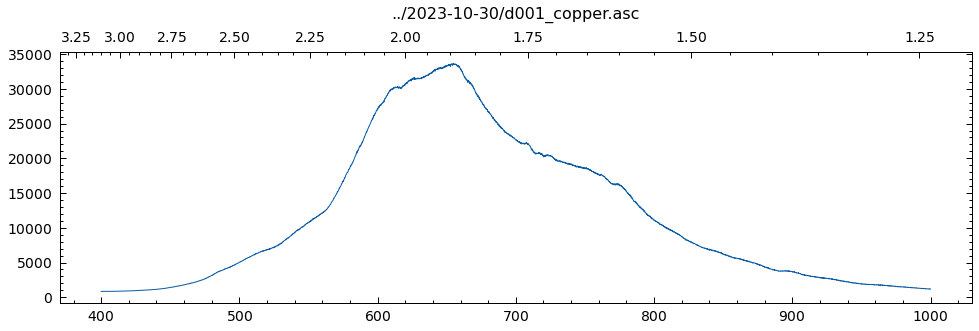

In [3]:
sel = 8
plt.figure()
plt.plot(wavelength[sel], intensity[sel])
plt.title(names[sel])
energy_ticks()
plt.tight_layout()
plt.show()

## running the thickness script

In [4]:
from scipy.signal import lombscargle
from scipy.constants import pi
import emd

def thickness(wavelength, intensity, thickness):
    """
    Calculate the signal for different thicknesses.

    thickness (np.array): $d n cos \theta2$
    
    Source: 
    A method for measuring and calibrating the thickness of thin films based on infrared interference technology
    """
    imf = emd.sift.sift(intensity)[:,0]
    nu = 1/wavelength
    w = 2*thickness * 2*pi
    pgram = lombscargle(nu, imf, w)
    return pgram

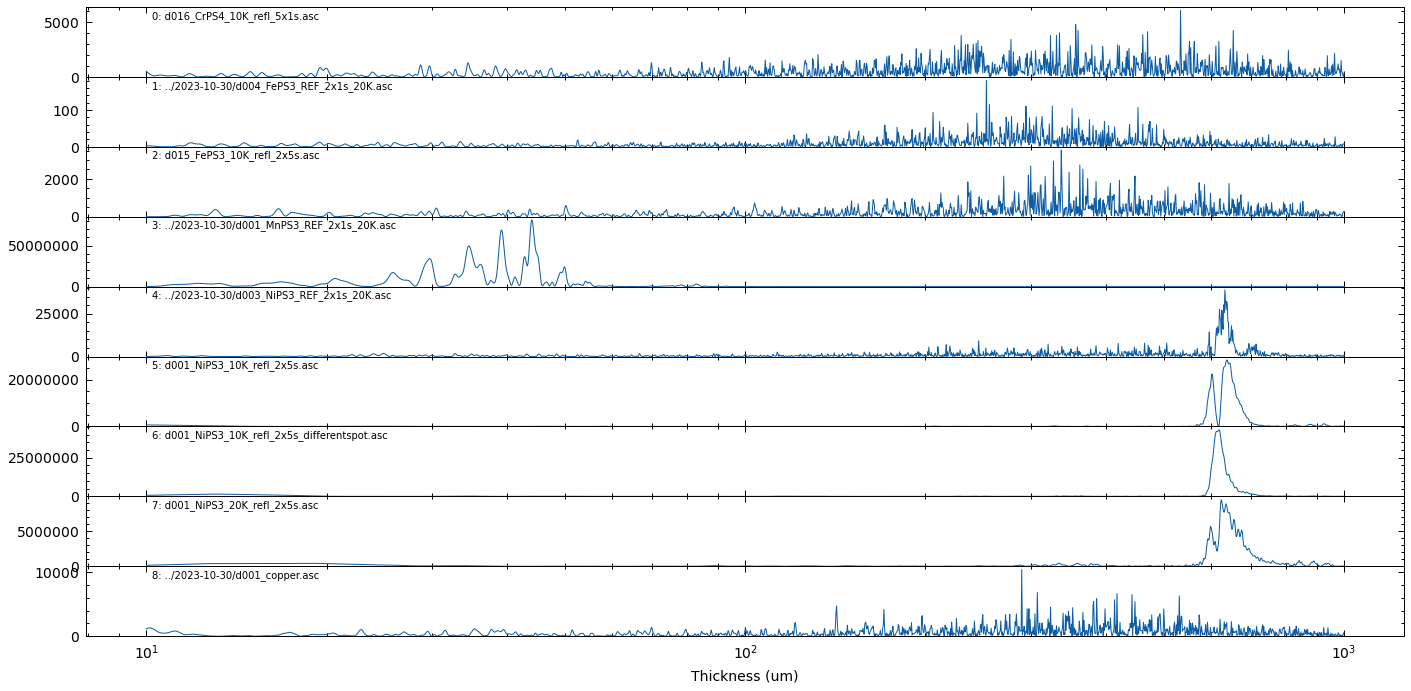

In [5]:
thicknesses = np.geomspace(10, 1e3, 2000) *1e3
thickness_signal = [thickness(w, i, thicknesses) for w, i in zip(wavelength, intensity)]

fig, ax = plt.subplots(len(names), 1, sharex=True, figsize=(10, 5))
for i,(n, intens, a) in enumerate(zip(names, thickness_signal, ax)):
    a.plot(thicknesses*1e-3, intens)
    a.text(0.05, 0.95, f"{i}: {n}", ha='left', va='top', transform=a.transAxes, fontsize=5)
    a.set_ylim(0, None)
plt.xscale("log")
plt.xlabel("Thickness (um)")
# disable scientific notation on top
for a in ax: a.ticklabel_format(axis="y", style="plain")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("../../figures/2023_10_31-thickness.png", dpi=300)
plt.show()

Where are the NiPS3 peaks for more than 1mm coming from?

The expected wavelength shift can be calculated:
\begin{align*}
\Delta\lambda &= \lambda - \frac{1}{\frac{1}{2 nd} + \frac{1}{\lambda}}\\ 
\end{align*}
To be $nd=5.4mm, \lambda=840nm$: $\Delta\lambda=0.065nm$ wich is the resolution limit of the spectrometer at $0.078 nm$.

NiPS3 and MnPS3 are quiet understandable.   
FePS3 and CrPS3 might just be noise? But there are peaks with an SNR of ~1.1.

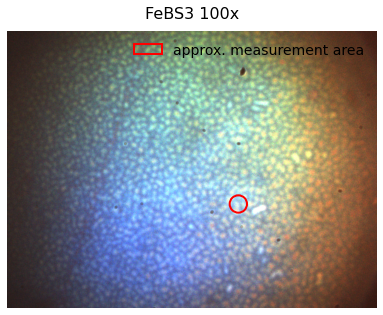

In [3]:
from PIL import Image

img1 = Image.open('FeBS3_100x.tiff', 'r')
plt.figure()
plt.imshow(img1)
plt.axis('off')
plt.title("FeBS3 100x")
# add a circle to the plot
circle = plt.Circle((800, 600), 30, color='r', fill=False, label="approx. measurement area")
plt.gcf().gca().add_artist(circle)
plt.legend()
plt.show()

# looking at luminscence spectra

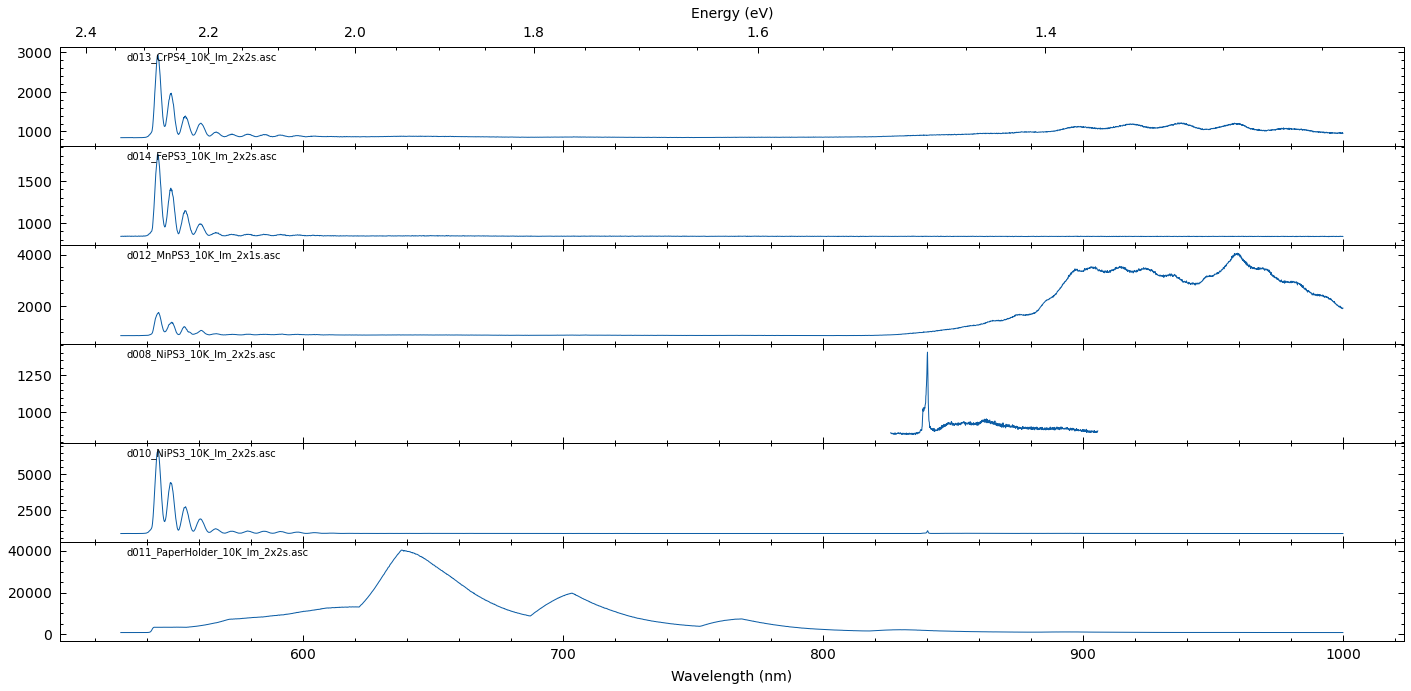

In [7]:
paths = glob("d*lm*.asc")
# paths = sorted(paths)

# sort by material
paths = sorted(paths, key=lambda x: (path.basename(x).split("_")[1], x))

names = [str.split(p, "/data/")[-1] for p in paths]

data = [np.loadtxt(p) for p in paths]
wavelength = [d[:,0] for d in data]
intensity = [d[:,1] for d in data]
del data

fig, ax = plt.subplots(len(names), 1, sharex=True, figsize=(10, 5))
for i,(n, wl, intens, a) in enumerate(zip(names, wavelength, intensity, ax)):
    a.plot(wl, intens)
    a.text(0.05, 0.95, n, ha='left', va='top', transform=a.transAxes, fontsize=5)
    a.set_ylim(
        intens.min() - 0.1*(intens.max()-intens.min()), 
        intens.max() + 0.1*(intens.max()-intens.min())
    )
plt.xlabel("Wavelength (nm)")
energy_ticks(ax[0]).set_xlabel("Energy (eV)")
for a in ax: a.ticklabel_format(axis="y", style="plain")
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig("../../figures/2023_10_31-lm.png")
plt.show()

# Work with maps

In [8]:
p = glob("d004*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values

p = glob("d004*.log1")[0]
x = np.loadtxt(p)

p = glob("d004*.log2")[0]
y = np.loadtxt(p)

name = str.split(p, "/data/")[-1]

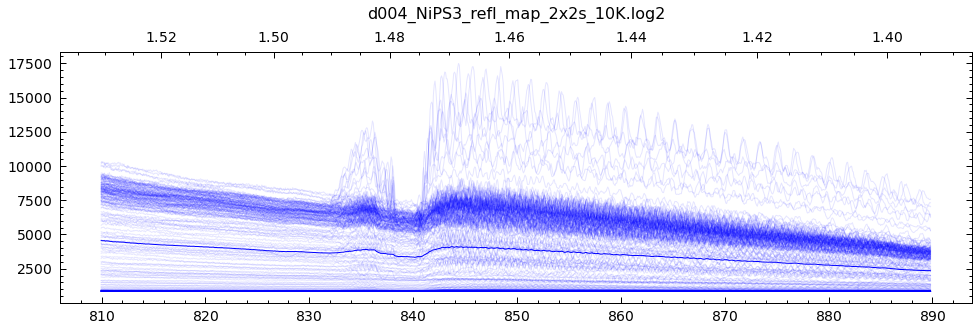

In [9]:
plt.figure()
for intens in intensity:
    plt.plot(wavelength, intens, alpha=0.1, color="b")
plt.plot(wavelength, intensity.mean(axis=0), color="b", label="mean")
energy_ticks()
plt.title(name)
plt.tight_layout()
plt.show()

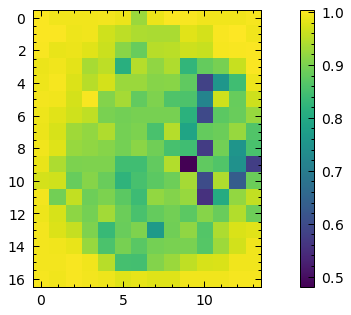

In [10]:
i = np.argmin(np.abs(wavelength - 840))
j = np.argmin(np.abs(wavelength - 835))
# z = intensity[:, i]
z = intensity[:, i] / intensity[:, j]
# z = intensity.mean(axis=-1)

d = np.unique(x).size

plt.figure()
plt.imshow(
    z.reshape(-1, d),
    # extent=[x.min(), x.max(), y.min(), y.max()],
)
plt.colorbar()
plt.show()

121: 8, 9


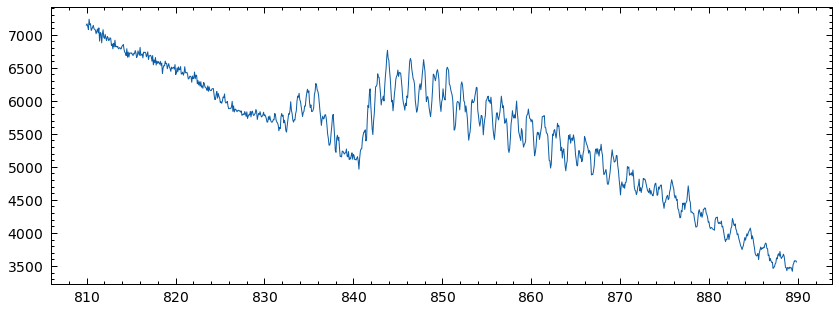

In [11]:
# i = np.argmin(z)
# i = 9*d+9
i = 9+8*d

print(f"{i}: {i//d}, {i%d}")
plt.figure()
plt.plot(wavelength, intensity[i])
plt.show()

![i004_NiPS3_20x.bmp](../../data/d231102_LO_MG/i004_NiPS3_20x.bmp)

## Hight map

In [12]:
p = glob("../../data/d231031_LO_MG/d004*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values

p = glob("../../data/d231031_LO_MG/d004*.log1")[0]
x = np.loadtxt(p)

p = glob("../../data/d231031_LO_MG/d004*.log2")[0]
y = np.loadtxt(p)

name = str.split(p, "/data/")[-1]

IndexError: list index out of range

In [ ]:
%%time
# thicknesses = np.geomspace(10, 1e3, 200) *1e3
thicknesses = np.linspace(500, 700, 100) *1e3
thickness_signal = np.array([thickness(wavelength, i, thicknesses) for i in intensity])
z = thicknesses[np.argmax(thickness_signal, axis=-1)]*1e-3

CPU times: user 3.52 s, sys: 55.9 ms, total: 3.58 s
Wall time: 3.66 s


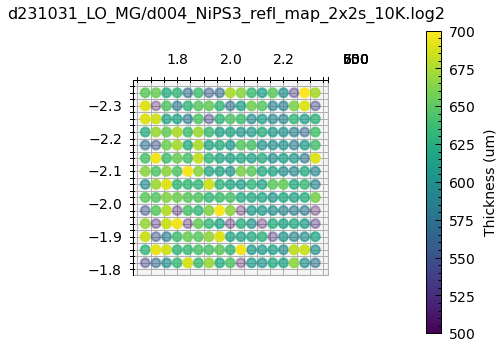

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
sct = ax.scatter(x, y, z, c=z, cmap="viridis")
fig.colorbar(sct, ax=ax, label="Thickness (um)")
fig.tight_layout()
ax.view_init(90,0)
ax.set_proj_type('ortho')
plt.title(name)
plt.show()

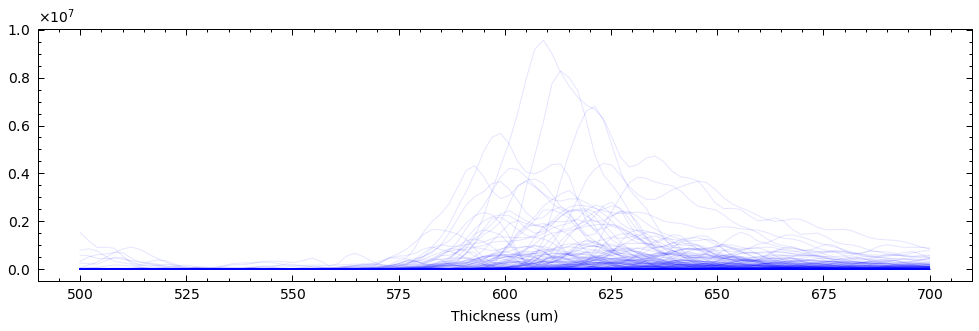

In [ ]:
plt.figure()
for s in thickness_signal:
    plt.plot(thicknesses*1e-3, s, alpha=0.1, color="b")
plt.xlabel("Thickness (um)")
plt.tight_layout()
plt.show()

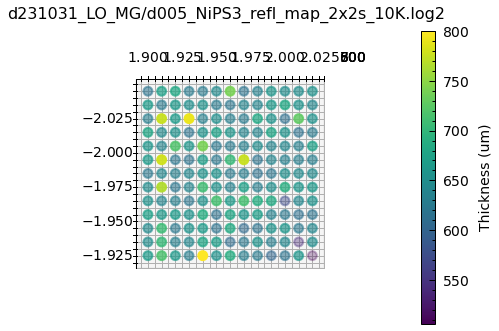

CPU times: user 2.17 s, sys: 794 ms, total: 2.97 s
Wall time: 2.08 s


In [ ]:
%%time
p = glob("../../data/d231031_LO_MG/d005*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values
p = glob("../../data/d231031_LO_MG/d005*.log1")[0]
x = np.loadtxt(p)
p = glob("../../data/d231031_LO_MG/d005*.log2")[0]
y = np.loadtxt(p)
name = str.split(p, "/data/")[-1]

# thicknesses = np.geomspace(10, 1e3, 200) *1e3
thicknesses = np.linspace(500, 800, 100) *1e3
thickness_signal = np.array([thickness(wavelength, i, thicknesses) for i in intensity])
z = thicknesses[np.argmax(thickness_signal, axis=-1)]*1e-3

fig = plt.figure()
ax = plt.axes(projection='3d')
sct = ax.scatter(x, y, z, c=z, cmap="viridis")
fig.colorbar(sct, ax=ax, label="Thickness (um)")
fig.tight_layout()
ax.view_init(90,0)
ax.set_proj_type('ortho')
plt.title(name)
plt.tight_layout()
plt.show()

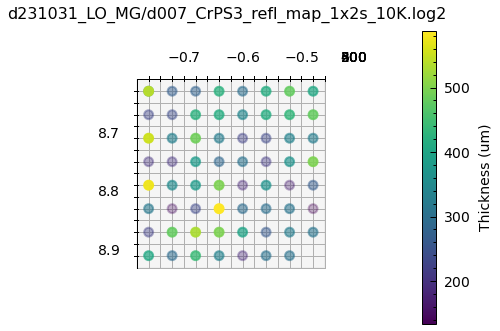

CPU times: user 4.43 s, sys: 645 ms, total: 5.08 s
Wall time: 4.38 s


In [ ]:
%%time
p = glob("../../data/d231031_LO_MG/d007*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values

p = glob("../../data/d231031_LO_MG/d007*.log1")[0]
x = np.loadtxt(p)[:len(intensity)]

p = glob("../../data/d231031_LO_MG/d007*.log2")[0]
y = np.loadtxt(p)[:len(intensity)]

name = str.split(p, "/data/")[-1]

thicknesses = np.geomspace(10, 600, 200) *1e3
thickness_signal = np.array([thickness(wavelength, i, thicknesses) for i in intensity])
z = thicknesses[np.argmax(thickness_signal, axis=-1)]*1e-3

fig = plt.figure()
ax = plt.axes(projection='3d')
sct = ax.scatter(x, y, z, c=z, cmap="viridis")
fig.colorbar(sct, ax=ax, label="Thickness (um)")
fig.tight_layout()
ax.view_init(90,0)
ax.set_proj_type('ortho')
plt.title(name)
plt.tight_layout()
plt.show()

![](../../data/d231102_LO_MG/i011_CrPS4_20x.bmp)

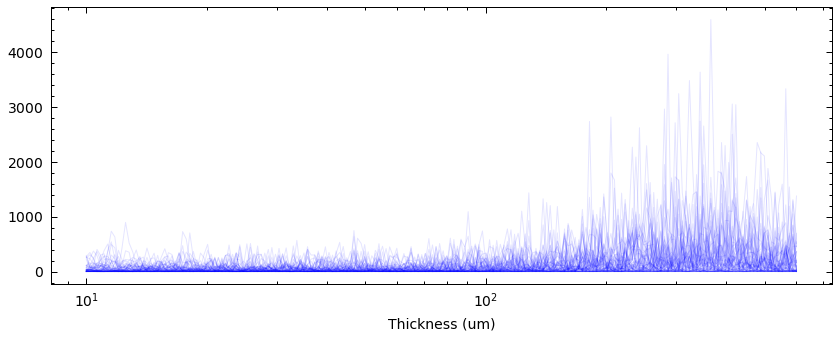

In [ ]:
plt.figure()
for s in thickness_signal:
    plt.plot(thicknesses*1e-3, s, alpha=0.1, color="b")
plt.xscale("log")
plt.xlabel("Thickness (um)")
plt.show()

# Try to make some signal usable


## MnPS3

In [ ]:
# import the NnPS3 map

p = glob("../../data/d231031_LO_MG/d006*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values

name = str.split(p, "/data/")[-1]

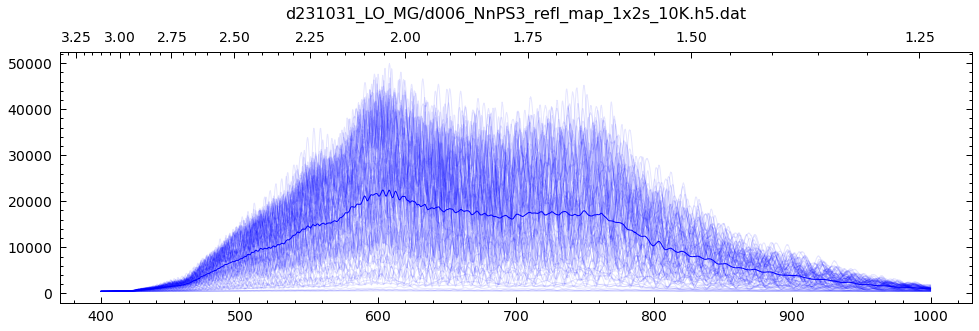

In [ ]:
plt.figure()
for intens in intensity:
    plt.plot(wavelength, intens, alpha=0.1, color="b")
plt.plot(wavelength, intensity.mean(axis=0), color="b", label="mean")
energy_ticks()
plt.title(name)
plt.tight_layout()
plt.show()

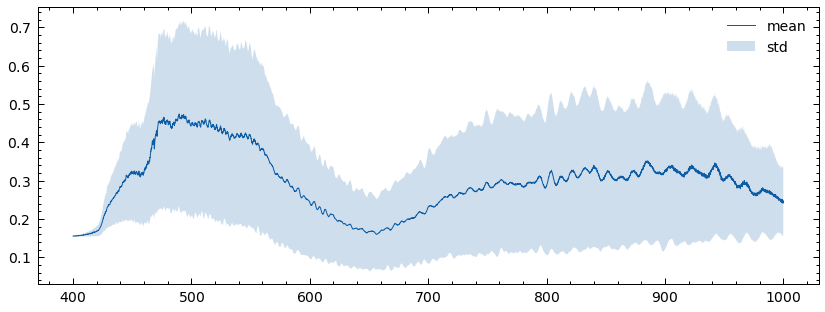

In [ ]:
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# d = np.loadtxt("../../data/d231102_LO_MG/d002_mirror_2x5s.asc")
d = np.loadtxt("../../data/d231030_LO_MG/d001_copper.asc")
wavelength_mirror = d[:,0]
intensity_mirror = d[:,1]

mirror = interp1d(wavelength_mirror, intensity_mirror, fill_value="extrapolate")

refl = intensity/mirror(wavelength)
refl /= refl.max()


plt.figure()
plt.plot(wavelength, refl.mean(0), label="mean")
plt.fill_between(
    wavelength, 
    refl.mean(axis=0) - refl.std(axis=0),
    refl.mean(axis=0) + refl.std(axis=0),
    alpha=0.2,
    label="std"
)
plt.legend()
plt.show()

### Try the same with NiPS3

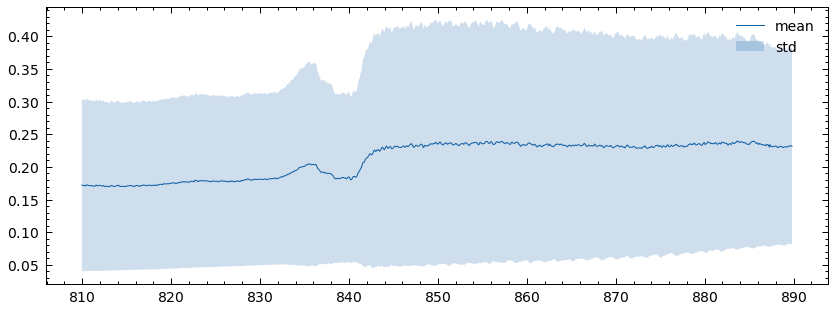

In [ ]:
from scipy.interpolate import interp1d

p = glob("../../data/d231031_LO_MG/d004*.dat")[0]
data = pd.read_csv(p, sep=" ").transpose()
wavelength = data.transpose().index
intensity = data.values

p = glob("../../data/d231031_LO_MG/d004*.log1")[0]
x = np.loadtxt(p)

p = glob("../../data/d231031_LO_MG/d004*.log2")[0]
y = np.loadtxt(p)

name = str.split(p, "/data/")[-1]

# d = np.loadtxt("../../data/d231102_LO_MG/d002_mirror_2x5s.asc")
d = np.loadtxt("../../data/d231030_LO_MG/d001_copper.asc")
wavelength_mirror = d[:,0]
intensity_mirror = d[:,1]

mirror = interp1d(wavelength_mirror, intensity_mirror, fill_value="extrapolate")

refl = intensity/mirror(wavelength)
refl /= refl.max()


plt.figure()
plt.plot(wavelength, refl.mean(0), label="mean")
plt.fill_between(
    wavelength, 
    refl.mean(axis=0) - refl.std(axis=0),
    refl.mean(axis=0) + refl.std(axis=0),
    alpha=0.2,
    label="std"
)
plt.legend()
plt.show()